<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Bond-Prices" data-toc-modified-id="Bond-Prices-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Bond Prices</a></span></li><li><span><a href="#Model-Setup" data-toc-modified-id="Model-Setup-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Model Setup</a></span><ul class="toc-item"><li><span><a href="#Nelson-Siegel" data-toc-modified-id="Nelson-Siegel-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Nelson Siegel</a></span></li></ul></li><li><span><a href="#Minimization" data-toc-modified-id="Minimization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Minimization</a></span></li><li><span><a href="#The-Spot-Rate-Curve" data-toc-modified-id="The-Spot-Rate-Curve-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>The Spot Rate Curve</a></span></li><li><span><a href="#Model-Prices-and-Residuals" data-toc-modified-id="Model-Prices-and-Residuals-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Model Prices and Residuals</a></span></li><li><span><a href="#Computing-the-Spot-Curve-for-all-historical-dates" data-toc-modified-id="Computing-the-Spot-Curve-for-all-historical-dates-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Computing the Spot Curve for all historical dates</a></span></li><li><span><a href="#Term-Structure-Evolution" data-toc-modified-id="Term-Structure-Evolution-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Term Structure Evolution</a></span></li></ul></div>

This notebook follows from another notebook "Spot Rate Curve Fitting" and continues to explore PCA hedging

# Principal Component Hedging

In [1]:
import numpy as np
import os
import QuantLib as ql
import pandas as pd
import datetime as dt
from MachineTrading.AlgoTradingApp.app_run import AppBond
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from MachineTrading.Utils.date_utils import date_to_quantlib, daterange
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from scipy.optimize import curve_fit
from prettytable import PrettyTable
import warnings

In [2]:
warnings.filterwarnings("ignore")

## Bond Prices

In [3]:
BTP_ISINS = [x.split('.')[0] for x in os.listdir("../AlgoTradingApp/Data/BondInfo") if 'IT0' in x]

bonds = {x:AppBond(x) for x in BTP_ISINS}

In [4]:
delete_isins = []
for isin, x in bonds.items():
    if x.bond.years_to_maturity() >= 30: 
        delete_isins.append(isin)

In [5]:
for x in delete_isins:
    del bonds[x]

In [6]:
year = 2022
month = 3
day = 22

reference_date = dt.date(year, month, day)
reference_date_ql = ql.Date(day, month, year)

for isin, b in bonds.items():
    b.update_data(reference_date)

data = []
for isin, b in bonds.items():
    data.append((isin, b.bond.maturity_date, b.years_to_maturity , b.price, b.yld, b.coupon))
    
data = sorted(data, key=lambda x: x[1])
data = pd.DataFrame(data)
data.columns = ['Isin', 'MaturityDate','YearsToMaturity', 'Price', 'Yield', 'Coupon']

In [7]:
data

,Isin,MaturityDate,YearsToMaturity,Price,Yield,Coupon
0,IT0005441719,"April 14th, 2022",0.062971,100.042491,-0.00735,0.00
1,IT0005447187,"June 14th, 2022",0.229979,100.144738,-0.00641,0.00
2,IT0005482937,"August 31st, 2022",0.443532,100.248925,-0.00571,0.00
3,IT0005440679,"November 29th, 2022",0.689938,100.293460,-0.00429,0.00
4,IT0005486748,"March 14th, 2023",0.977413,100.435310,-0.00446,0.00
5,IT0005424251,"January 15th, 2024",1.817933,99.687123,0.00173,0.00
6,IT0005408502,"July 1st, 2025",3.277207,103.602717,0.00734,1.85
7,IT0005454241,"August 1st, 2026",4.361396,95.583117,0.01039,0.00
8,IT0005390874,"January 15th, 2027",4.818617,98.770748,0.01113,0.85
9,IT0005433690,"March 15th, 2028",5.982204,93.501309,0.01387,0.25


## Model Setup

### Nelson Siegel

In [8]:
def nelson_siegel_rate(T, tau, b0, b1, b2):
    x = T/tau
    r = b0 + (b1+b2) * (1-np.exp(-x))/x - b2*np.exp(-x)
    return r

def nelson_siegel_discount_factor(T, tau, b0, b1, b2):
    df = np.exp(-nelson_siegel_rate(T, tau, b0, b1, b2)*T)
    return df

def nelson_siegel_bond_price(b, tau, b0, b1, b2, eval_date):    
    if isinstance(eval_date, dt.date):
        eval_date = date_to_quantlib(eval_date)
        
    cashflows = b.bond.bond.cashflows()
    cf = [(x.date(), x.amount()/100, b.bond.pricingDayCounter.yearFraction(eval_date, x.date()))
          for x in cashflows]
    cf = [x for x in cf if x[2] > 0]

    coupons = np.array([x[1] for x in cf])
    terms = np.array([x[2] for x in cf])

    cpns = 100 * (coupons[:-1] * nelson_siegel_discount_factor(terms[:-1], tau, b0, b1, b2))
    face = 100 * (nelson_siegel_discount_factor(terms[-1], tau, b0, b1, b2))
    price = np.sum(cpns)+face
    return price

def nelson_siegel_price_error(b, tau, b0, b1, b2, eval_date):
    ns_price = nelson_siegel_bond_price(b, tau, b0, b1, b2, eval_date)
    price_error = (ns_price - b.price) ** 2
    return price_error

def nelson_siegel_curve_fit(bonds, eval_date, disp=False):
    
    def fitting_func(args):
        tau, b0, b1, b2 = args
        total_error = 0
        for isin, b in bonds.items():
            price_error = nelson_siegel_price_error(b, tau, b0, b1, b2, eval_date)
            total_error += price_error
        return np.sqrt(total_error)

    ns_minimization_result = minimize(fitting_func, 
                                      x0=np.array([1, 0, 0, 0]),
                                      bounds=[(0, None), (0, 5), (-5, 5), (-5, 5)],
#                                       constraints = ({'type': 'ineq', 'fun': lambda x: x[1] + x[2]}),
                                      tol=1e-8, 
                                      options={'disp': disp}
                                     )
    return ns_minimization_result

## Minimization 

In [9]:
ne_minimization_result = nelson_siegel_curve_fit(bonds, reference_date_ql, True)

## The Spot Rate Curve

In [10]:
params = ne_minimization_result['x']

estandard_maturities = np.linspace(0.5, 30, 60)

zero_coupon_spot_curve = nelson_siegel_rate(estandard_maturities, 
                                            params[0], params[1], params[2], params[3])

In [11]:
np.round(params, 4)

array([ 1.2439,  0.0291, -0.0338, -0.0352])

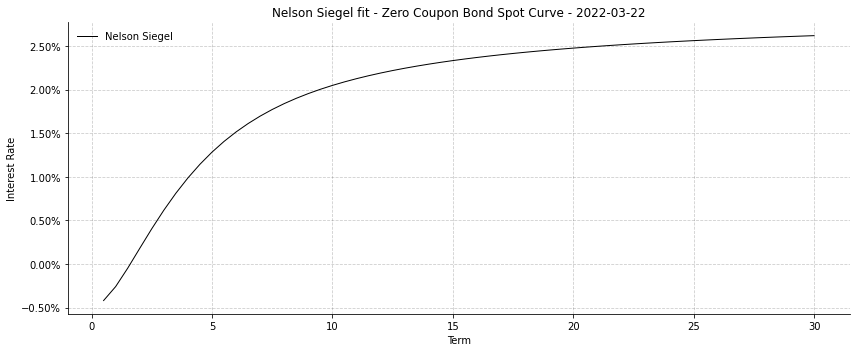

In [12]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(estandard_maturities, zero_coupon_spot_curve*100, color='k', lw=1, label='Nelson Siegel')

ax.legend(loc='best', frameon=False)
ax.set_xlabel("Term")
ax.set_ylabel("Interest Rate")
ax.set_title(f"Nelson Siegel fit - Zero Coupon Bond Spot Curve - {dt.date(2022,3,22)}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Model Prices and Residuals

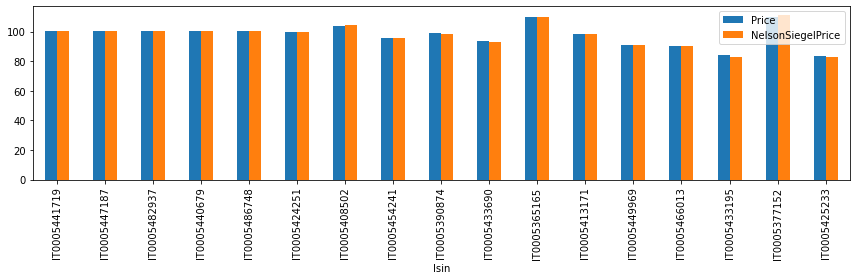

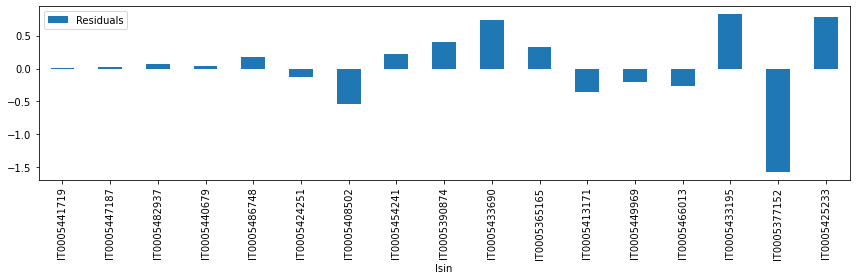

In [13]:
computed_prices = {}
for isin, b in bonds.items():
    computed_prices[isin] = nelson_siegel_bond_price(b, params[0], params[1], params[2], params[3], reference_date_ql)

data['NelsonSiegelPrice'] = data['Isin'].map(computed_prices)

data.set_index('Isin')[['Price', 'NelsonSiegelPrice']].plot(kind='bar', figsize=(12,4))
plt.tight_layout()
plt.show()

data['Residuals'] = data['Price']-data['NelsonSiegelPrice']

data.set_index('Isin')[['Residuals']].plot(kind='bar', figsize=(12,4))
plt.tight_layout()
plt.show()

## Computing the Spot Curve for all historical dates

In [14]:
curves = {}
fits = {}

date_range = daterange(dt.date(2021,9,1), dt.date(2022,3,23))
eval_dates = list(date_range)

for d in tqdm(eval_dates):
    
    ql_date = date_to_quantlib(d)
    for isin, b in bonds.items():
        b.update_data(d)

    res = nelson_siegel_curve_fit(bonds, ql_date, False)
    spot_curve = nelson_siegel_rate(estandard_maturities, res['x'][0], res['x'][1], res['x'][2], res['x'][3])
    
    curves[d] = spot_curve
    fits[d] = res['x']

  0%|          | 0/203 [00:00<?, ?it/s]

In [15]:
def logistic(x, k, x0=0.5):
    return 1 / (1+np.exp(-k*(x-x0)))

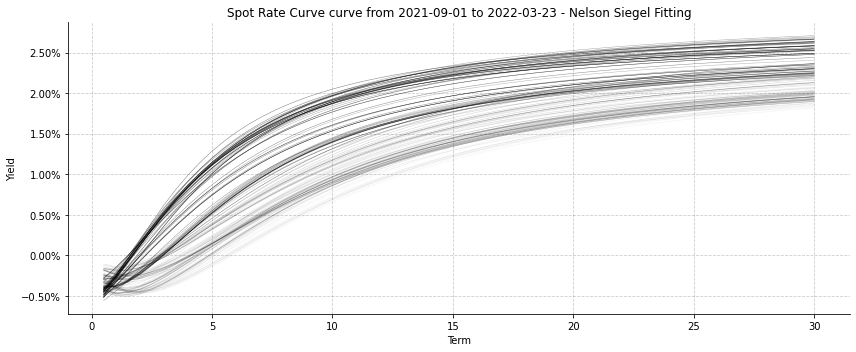

In [16]:
fig, ax = plt.subplots(figsize=(12,5))
for i, (d, cv) in enumerate(curves.items()):
    ax.plot(estandard_maturities, cv*100, color='k', 
            alpha=logistic(i, 0.02, 200), 
            lw=0.5)
    
ax.set_xlabel("Term")
ax.set_ylabel("Yield")
ax.set_title(f"Spot Rate Curve curve from {dt.date(2021,9,1)} to {dt.date(2022,3,23)} - Nelson Siegel Fitting")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

## Term Structure Evolution

In [17]:
term_structure_evolution = pd.DataFrame.from_dict(curves).T
term_structure_evolution.columns = [str(x) for x in estandard_maturities]

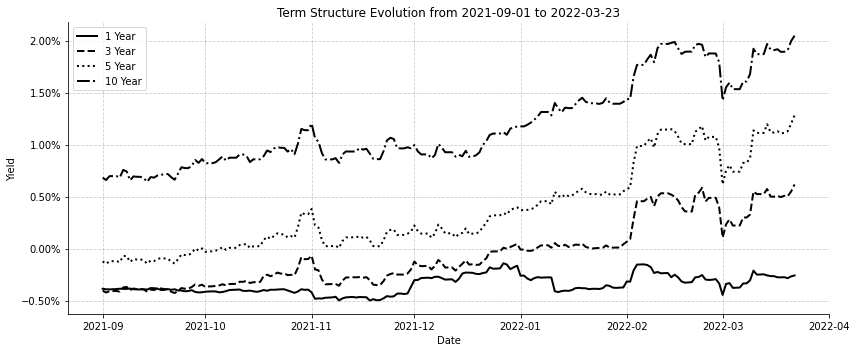

In [18]:
fig, ax = plt.subplots(figsize=(12,5))

lw = 2
ax.plot(term_structure_evolution.index, term_structure_evolution["1.0"]*100, color='k', lw=lw, label='1 Year')
ax.plot(term_structure_evolution.index, term_structure_evolution["3.0"]*100, color='k', ls='--', lw=lw, label='3 Year')
ax.plot(term_structure_evolution.index, term_structure_evolution["5.0"]*100, color='k', ls=':', lw=lw, label='5 Year')
ax.plot(term_structure_evolution.index, term_structure_evolution["10.0"]*100, color='k', ls='-.', lw=lw, label='10 Year')
    
ax.set_xlabel("Date")
ax.set_ylabel("Yield")
ax.set_title(f"Term Structure Evolution from {dt.date(2021,9,1)} to {dt.date(2022,3,23)}")
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.grid(axis='both', alpha=0.2, color='k', ls='--')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend()
plt.tight_layout()
plt.show()